

损失函数是模型优化的目标，用于衡量在无数的参数取值中，哪一个是最理想的。损失函数的计算在训练过程的代码中，每一轮训练代码的过程均相同：先根据输入数据正向计算预测输出，再根据预测值和真实值计算损失，最后根据损失反向传播梯度并更新参数。

在之前的方案中，我们复用了房价预测模型的损失函数-均方误差。虽然从预测效果来看，使用均方误差使得损失不断下降，模型的预测值逐渐逼近真实值，但模型的最终效果不够理想。究其根本，不同的机器学习任务有各自适宜的损失函数，这里我们详细剖析一下其中的缘由：

房价预测是回归任务，而手写数字识别属于分类任务。分类任务中使用均方误差作为损失存在逻辑和效果上的缺欠，比如房价可以是0-9之间的任何浮点数，手写数字识别的数字只可能是0-9之间的10个实数值（标签）。在房价预测的案例中，因为房价本身是一个连续的实数值，以模型输出的数值和真实房价差距作为损失函数（loss）是符合道理的。但对于分类问题，真实结果是标签，而模型输出是实数值，导致两者相减的物理含义缺失。

这里我们做一个假设：如果模型能输出10个标签的概率，对应真实标签的概率输出尽可能接近100%，而其他标签的概率输出尽可能接近0%，且所有输出概率之和为1。这是一种更合理的假设！与此对应，真实的标签值可以转变成一个10维度的one-hot向量，在对应数字的位置上为1，其余位置为0，比如标签“6”可以转变成[0,0,0,0,0,1,0,0,0,0]。

为了实现上述假设，需要引入Softmax函数。它可以将原始输出转变成对应标签的概率，**Softmax函数公式如下**：

$$softmax(x_i) = \frac {e^{x_i}}{\sum_{j=0}^N{e^x_j}}, i=0, ..., C-1$$



$C$是标签类别个数。
从公式的形式可见，每个输出的范围均在0~1之间，且所有输出之和等于1，这是这种变换后可被解释成概率的基本前提。对应到代码上，我们需要在网络定义部分修改输出层：self.fc = FC(name_scope, size=10, act='softmax')，即是对全连接层FC的输出加一个softmax运算。



   
在该假设下，采用均方误差衡量两个概率的差别不是理论上最优的。人们习惯使用交叉熵误差作为分类问题的损失衡量，因为后者有更合理的物理解释，详见《机器学习的思考故事》。

**交叉熵的公式如下：**

$$ L = -[\sum_{k=1}^{n} t_k\log y_k +(1- t_k)\log(1-y_k)] $$
   
其中，$\log$表示以$e$为底数的自然对数。$y_k$代表模型输出，$t_k$代表各个标签。$t_k$中只有正确解的标签为1，其余均为0（one-hot表示）。因此，交叉熵只计算对应着“正确解”标签的输出的自然对数。比如，假设正确标签的索引是“2”，与之对应的神经网络的输出是0.6，则交叉熵误差是$−\log 0.6 = 0.51$；若“2”对应的输出是0.1，则交叉熵误差为$−\log 0.1 = 2.30$。由此可见，交叉熵误差的值是由正确标签所对应的输出结果决定的。

自然对数的函数曲线可由如下代码显示。


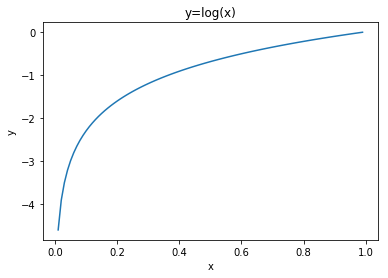

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0.01,1,0.01)
y = np.log(x)
plt.title("y=log(x)") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y)
plt.show()
plt.figure()

如自然对数的图形所示，当x等于1时，y为0；随着x向0靠近，y逐渐变小。因此，正确解标签对应的输出越大，交叉熵的值越接近0；当输出为1时，交叉熵误差为0。反之，如果正确解标签对应的输出越小，则交叉熵的值越大。

在手写数字识别任务中，如果在现有代码中将模型的损失函数替换成交叉熵（cross_entropy），仅改动三行代码即可：在读取数据部分，将标签的类型设置成int，体现它是一个标签而不是实数值（飞桨框架默认将标签处理成int64）；在网络定义部分，将输出层改成“输出十个标签的概率”的模式；以及在训练过程部分，将损失函数从均方误差换成交叉熵。

- 数据处理部分：label = np.reshape(labels[i], [1]).astype('int64')
- 网络定义部分：self.fc = FC(name_scope, size=10, act='softmax')
- 训练过程部分：loss = fluid.layers.cross_entropy(predict, label)

如下是在数据处理部分，修改标签变量Label的格式。
- 从：label = np.reshape(labels[i], [1]).astype('float32')
- 到：label = np.reshape(labels[i], [1]).astype('int64')

In [3]:
#修改标签数据的格式，从float32到int64
import os
import random
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, FC
import numpy as np
from PIL import Image

import gzip
import json

# 定义数据集读取器
def load_data(mode='train'):

    # 数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]

    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('int64')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

如下是在网络定义部分，修改输出层结构。
- 从：self.fc = FC(name_scope, size=1, act=None)
- 到：self.fc = FC(name_scope, size=10, act='softmax')

In [5]:
# 定义模型结构
class MNIST(fluid.dygraph.Layer):
     def __init__(self, name_scope):
         super(MNIST, self).__init__(name_scope)
         name_scope = self.full_name()
         # 定义一个卷积层，使用relu激活函数
         self.conv1 = Conv2D(name_scope, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义一个池化层，池化核为2，步长为2，使用最大池化方式
         self.pool1 = Pool2D(name_scope, pool_size=2, pool_stride=2, pool_type='max')
         # 定义一个卷积层，使用relu激活函数
         self.conv2 = Conv2D(name_scope, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义一个池化层，池化核为2，步长为2，使用最大池化方式
         self.pool2 = Pool2D(name_scope, pool_size=2, pool_stride=2, pool_type='max')
         # 定义一个全连接层，输出节点数为10 
         self.fc = FC(name_scope, size=10, act='softmax')
    # 定义网络的前向计算过程
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = self.pool1(x)
         x = self.conv2(x)
         x = self.pool2(x)
         x = self.fc(x)
         return x

如下代码仅修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题）。
- 从：loss = fluid.layers.square_error_cost(predict, label)
- 到：loss = fluid.layers.cross_entropy(predict, label)

In [3]:
#仅修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题）
with fluid.dygraph.guard():
    model = MNIST("mnist")
    model.train()
    #调用加载数据的函数
    train_loader = load_data('train')
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01)
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            image_data, label_data = data
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
            
            #前向计算的过程
            predict = model(image)
            
            #计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
            loss = fluid.layers.cross_entropy(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    #保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [2.4464767]
epoch: 0, batch: 200, loss is: [0.35378253]
epoch: 0, batch: 400, loss is: [0.19394642]
epoch: 1, batch: 0, loss is: [0.2654959]
epoch: 1, batch: 200, loss is: [0.26667175]
epoch: 1, batch: 400, loss is: [0.22529164]
epoch: 2, batch: 0, loss is: [0.15588592]
epoch: 2, batch: 200, loss is: [0.20306593]
epoch: 2, batch: 400, loss is: [0.25867027]
epoch: 3, batch: 0, loss is: [0.2143673]
epoch: 3, batch: 200, loss is: [0.10330768]
epoch: 3, batch: 400, loss is: [0.16994831]
epoch: 4, batch: 0, loss is: [0.19997822]
epoch: 4, batch: 200, loss is: [0.05874193]
epoch: 4, batch: 400, loss is: [0.1538875]


虽然上述训练过程的损失明显比使用均方误差算法要小，但因为损失函数量纲的变化，我们无法从比较两个不同的Loss得出谁更加优秀。怎么解决这个问题呢？我们可以回归到问题的直接衡量，谁的分类准确率高来判断。在后面介绍完计算准确率和作图的内容后，读者可以自行测试采用不同损失函数下，模型准确率的高低。

因为我们修改了模型的输出格式，所以使用模型做预测时的代码也需要做相应的调整。从模型输出10个标签的概率中选择最大的，将其标签编号输出。

In [13]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im.show()
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化
    im = 1.0 - im / 255.
    return im

# 定义预测过程
with fluid.dygraph.guard():
    model = MNIST("mnist")
    params_file_path = 'mnist'
    img_path = './work/example_0.jpg'
    # 加载模型参数
    model_dict, _ = fluid.load_dygraph("mnist")
    model.load_dict(model_dict)
    
    model.eval()
    tensor_img = load_image(img_path)
    #模型反馈10个分类标签的对应概率
    results = model(fluid.dygraph.to_variable(tensor_img))
    #取概率最大的标签作为预测输出
    lab = np.argsort(results.numpy())
    print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  0
